In [81]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

%matplotlib inline

# Load Dataset

In [82]:
info = pd.read_csv(r'C:\Users\juanchen\Desktop\120 jifu zhao\data\cc_info.csv')
info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [83]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   credit_card        984 non-null    int64 
 1   city               984 non-null    object
 2   state              984 non-null    object
 3   zipcode            984 non-null    int64 
 4   credit_card_limit  984 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 38.6+ KB


In [84]:
info.describe()

,credit_card,zipcode,credit_card_limit
count,9.840000e+02,984.000000,984.000000
mean,5.410432e+15,17895.316057,12321.138211
std,2.545234e+15,23778.651105,7398.449174
min,1.003715e+15,690.000000,2000.000000
25%,3.316062e+15,3280.000000,7000.000000
50%,5.365218e+15,5820.000000,10000.000000
75%,7.562153e+15,18101.250000,16000.000000
max,9.999757e+15,98401.000000,55000.000000


In [85]:
transaction = pd.read_csv(r'C:\Users\juanchen\Desktop\120 jifu zhao\data\transactions.csv', parse_dates=['date'])
transaction.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [86]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   credit_card                294588 non-null  int64         
 1   date                       294588 non-null  datetime64[ns]
 2   transaction_dollar_amount  294588 non-null  float64       
 3   Long                       294588 non-null  float64       
 4   Lat                        294588 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 11.2 MB


In [87]:
transaction.describe()

,credit_card,transaction_dollar_amount,Long,Lat
count,2.945880e+05,294588.000000,294588.000000,294588.000000
mean,5.424562e+15,86.008036,-76.235238,40.937669
std,2.555803e+15,124.655954,20.135015,5.391695
min,1.003715e+15,0.010000,-179.392887,-68.046553
25%,3.344214e+15,29.970000,-80.209708,40.487726
50%,5.353426e+15,58.470000,-73.199737,42.403066
75%,7.646245e+15,100.400000,-72.091933,43.180015
max,9.999757e+15,999.970000,179.917513,78.914330


# Data Processing

In [88]:
data = pd.merge(left=transaction, right=info, on='credit_card', how='left')
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [89]:
# extract month, weekday, and hour information
data['month'] = data['date'].apply(lambda x: x.month)
data['day'] = data['date'].apply(lambda x: x.day)
data['weekday'] = data['date'].apply(lambda x: x.dayofweek)
data['hour'] = data['date'].apply(lambda x: x.hour)

# drop useless features
data = data.drop(labels='date', axis=1)

data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20


# Question 1
Your boss wants to identify those users that in your dataset never went above the monthly credit card limit (calendar month). The goal of this is to automatically increase their limit. Can you send him the list of Ids?

In [90]:
def monthly_transaction(df):
    """ function to calculate montly total transactions """
    total_trans = df['transaction_dollar_amount'].sum()
    credit_limit = df['credit_card_limit'].values[0]
    
    return pd.Series([total_trans, credit_limit], index=['total_transaction', 'credit_limit'])

In [91]:
# find users who never exceed credit limit
grouped = data.groupby(['credit_card', 'month']).apply(monthly_transaction)
grouped = grouped.reset_index()

grouped['exceed'] = (grouped['total_transaction'] > grouped['credit_limit']).astype(int)
grouped_sum = grouped.groupby('credit_card')['exceed'].sum().reset_index()

lists = grouped_sum[grouped_sum['exceed'] == 0][['credit_card']]

print('Valid users:\t', len(lists))
lists.head()

Valid users:	 862


,credit_card
0,1003715054175576
1,1013870087888817
2,1023820165155391
3,1073931538936472
4,1077622576192810


So, there are 862 credit cards in total that never exceed their credit limit.

# Question 2
On the other hand, she wants you to implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that. We assume here that at the beginning of the new month, user total money spent gets reset to zero (i.e. she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

In [92]:
def alert(data, month, day):
    """ function to return the list of credit cards that exceed the limit """
    data = data[(data['month'] == month) & (data['day'] <= day)]
    limit = data.groupby('credit_card')['credit_card_limit'].min().reset_index()
    transaction = data.groupby('credit_card')['transaction_dollar_amount'].sum().reset_index()
    
    merged = pd.merge(left=transaction, right=limit, on='credit_card', how='left')
    result = merged[merged['transaction_dollar_amount'] > merged['credit_card_limit']]
    
    return result

In [93]:
# example
alert(data, month=8, day=20)

,credit_card,transaction_dollar_amount,credit_card_limit
194,2850146878241916,4012.81,4000
319,3936887050542904,5352.07,4000
341,4118286032166087,3416.52,3000
383,4462290711836916,3119.53,2000
525,5723635641134781,2161.30,2000
698,7299183791723634,7074.49,7000
772,7850942767136368,5704.00,4000
834,8522875529951473,5860.89,5000
874,8972201384562696,5266.08,5000


# Question 3
Finally, your boss is very concerned about frauds cause they are a huge cost for credit card companies. She wants you to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further.

In [94]:
data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20


There are some features that cannot be directly used, such as `Long`, `Lat`, `city`, `state`, `zipcode`. However, these information is important towards anomaly detection. One idea is to replace `city`, `state`, `zipcode` with the user's home latitude and longitude. In this work, to simplify the work, I use the median of `Long` and `Lat` as the indicator of user's home address.

In [95]:
# calculate the median for Longitude and Latitude
address = data.groupby('credit_card')['Long', 'Lat'].mean().reset_index()
address = address.rename(columns={'Long': 'Long_median', 'Lat': 'Lat_median'})
data = pd.merge(left=data, right=address, on='credit_card', how='left')

In [96]:
# calculate the distance
data['distance'] = np.sqrt((data['Long'] - data['Long_median'])**2 + (data['Lat'] - data['Lat_median'])**2)

For transaction and credit limit information, two more useful information are extracted:
* ratio of transaction and transaction median
* ratio of transaction and credit limit

In [97]:
# calculate user transaction median
median = data.groupby('credit_card')['transaction_dollar_amount'].median().reset_index()
median = median.rename(columns={'transaction_dollar_amount': 'transaction_median'})
data = pd.merge(left=data, right=median, on='credit_card', how='left')

In [98]:
# extract useful information
data['transaction_to_median'] = data['transaction_dollar_amount'] / data['transaction_median']
data['transaction_to_limit'] = data['transaction_dollar_amount'] / data['credit_card_limit']

data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,Long_median,Lat_median,distance,transaction_median,transaction_to_median,transaction_to_limit
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0,-77.583829,39.610299,2.672342,93.73,0.467086,0.002189
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22,-77.583829,39.610299,2.671878,93.73,1.100501,0.005158
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18,-77.583829,39.610299,2.719557,93.73,0.517977,0.002427
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19,-77.583829,39.610299,2.678229,93.73,1.452897,0.006809
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20,-77.583829,39.610299,2.712572,93.73,0.766243,0.003591


In [99]:
# drop useless features
labels = ['transaction_dollar_amount', 'Long', 'Lat', 'city', 'state', 'zipcode', 'credit_card_limit', 
          'month', 'day', 'Long_median', 'Lat_median', 'transaction_median']
data = data.drop(labels=labels, axis=1)
data.head()

,credit_card,weekday,hour,distance,transaction_to_median,transaction_to_limit
0,1003715054175576,4,0,2.672342,0.467086,0.002189
1,1003715054175576,5,22,2.671878,1.100501,0.005158
2,1003715054175576,0,18,2.719557,0.517977,0.002427
3,1003715054175576,3,19,2.678229,1.452897,0.006809
4,1003715054175576,0,20,2.712572,0.766243,0.003591


Now, let's first visualize the data in 2D throught PCA.

In [100]:
# normalize the data
x = data[['weekday', 'hour', 'distance', 'transaction_to_median', 'transaction_to_limit']]
#x = data[['distance', 'transaction_to_median', 'transaction_to_limit']]
# x = data[['distance', 'transaction_to_median', 'transaction_to_limit']]
scaler = StandardScaler()
norm_x = scaler.fit_transform(x)

pca = PCA(n_components=2, random_state=42)
pca_x = pca.fit_transform(norm_x)



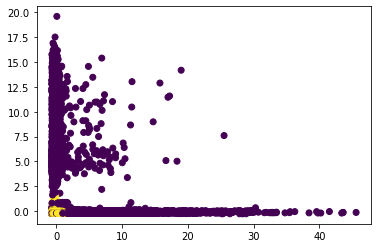

(29458, 2)
(265130, 2)


In [127]:
#与kmeans不同，label是-1,1
forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, 
                         max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)
forest = forest.fit(norm_x)
score = forest.decision_function(norm_x)
label = forest.predict(norm_x)

plt.scatter(pca_x[:, 0], pca_x[:, 1], c=label)   
plt.show()
print(pca_x[label==-1].shape)
print(pca_x[label==1].shape) 

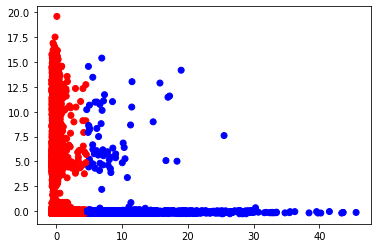

(290700, 2)
(3888, 2)


In [122]:
kmmodel = KMeans(n_clusters=2, init='k-means++', random_state=42, n_jobs=-1).fit(norm_x) 
label2 = kmmodel.predict(norm_x)

color = ('r', 'b','y','g','c','k')
label_color = np.array(color)[label2]
plt.scatter(pca_x[:, 0], pca_x[:, 1], c=label_color)
plt.show()

print(pca_x[label2==0].shape)
print(pca_x[label2==1].shape) 

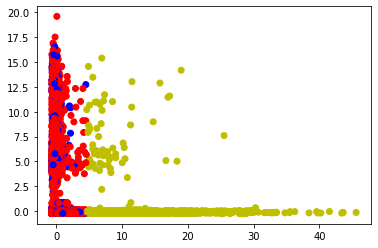

(244080, 2)
(46711, 2)
(3797, 2)


In [123]:
kmmodel = KMeans(n_clusters=3, init='k-means++', random_state=42, n_jobs=-1).fit(norm_x) 
label3 = kmmodel.predict(norm_x)
color = ('r', 'b','y','g','c','k')
label_color = np.array(color)[label3]
plt.scatter(pca_x[:, 0], pca_x[:, 1], c=label_color)
plt.show()
print(pca_x[label3==0].shape)
print(pca_x[label3==1].shape)
print(pca_x[label3==2].shape)

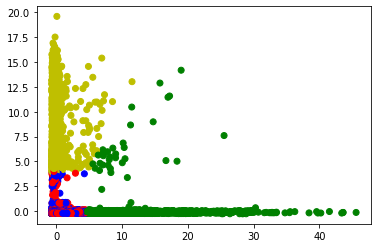

(136101, 2)
(150765, 2)
(3958, 2)
(3764, 2)


In [124]:

kmmodel = KMeans(n_clusters=4, init='k-means++', random_state=42, n_jobs=-1).fit(norm_x) 
label4 = kmmodel.predict(norm_x)
color = ('r', 'b','y','g','c','k')
label_color = np.array(color)[label4]
plt.scatter(pca_x[:, 0], pca_x[:, 1], c=label_color)
plt.show()
print(pca_x[label4==0].shape)
print(pca_x[label4==1].shape)
print(pca_x[label4==2].shape)
print(pca_x[label4==3].shape)


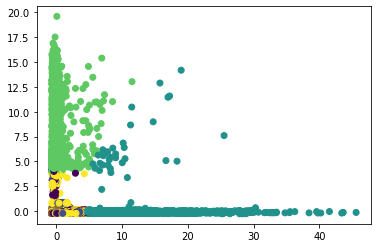

(77031, 2)
(45990, 2)
(3699, 2)
(3935, 2)
(163933, 2)


In [118]:
kmmodel = KMeans(n_clusters=5, init='k-means++', random_state=42, n_jobs=-1).fit(norm_x) 
label5 = kmmodel.predict(norm_x)
color = ('r', 'b','y','g','c','k')
label_color = np.array(color)[label5]
plt.scatter(pca_x[:, 0], pca_x[:, 1], c=label_color)
plt.show()
print(pca_x[label5==0].shape)
print(pca_x[label5==1].shape)
print(pca_x[label5==2].shape)
print(pca_x[label5==3].shape)
print(pca_x[label5==4].shape)

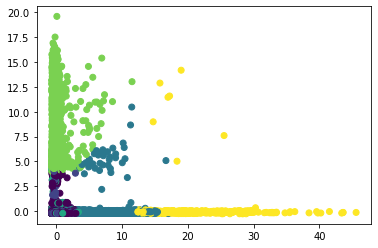

(163222, 2)
(76703, 2)
(4335, 2)
(45785, 2)
(3926, 2)
(617, 2)


In [120]:
kmmodel = KMeans(n_clusters=6, init='k-means++', random_state=42, n_jobs=-1).fit(norm_x) 
label6 = kmmodel.predict(norm_x)

color = ('r', 'b','y','g','c','k')
label_color = np.array(color)[label6]
plt.scatter(pca_x[:, 0], pca_x[:, 1], c=label_color)
plt.show()
print(pca_x[label6==0].shape)
print(pca_x[label6==1].shape)
print(pca_x[label6==2].shape)
print(pca_x[label6==3].shape)
print(pca_x[label6==4].shape)
print(pca_x[label6==5].shape)

In [73]:
#执行不了，silhouette计算时间开销太大，一晚上都算不完
silhouettes = []
start = time.clock()

for k in range(2, 30):   
    kmmodel = KMeans(n_clusters=k, init='k-means++', random_state=42, n_jobs=-1).fit(norm_x) 
    label = kmmodel.predict(norm_x)
    print(silhouette_score(norm_x, label))
  
silhouettes.append(silhouette_score(norm_x, label))

end = time.clock()
print(start)
print(end)
 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax[1].plot(range(2, 30), silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

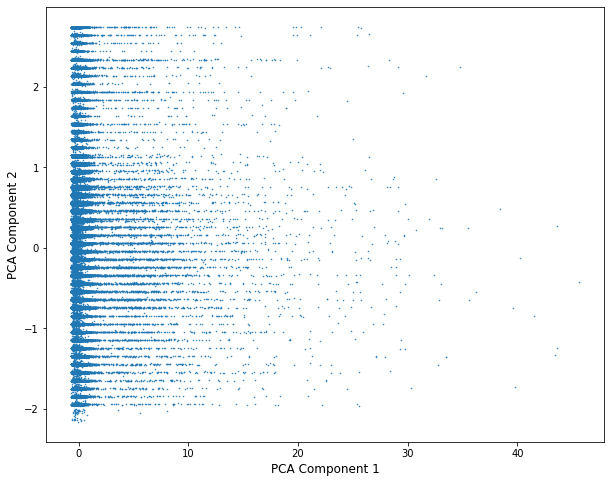

In [47]:
# apply PCA
pca = PCA(n_components=2, random_state=42)
pca_x = pca.fit_transform(norm_x)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(pca_x[:, 0], pca_x[:, 1], '.', markersize=1)
ax.set_xlabel('PCA Component 1', fontsize=12)
ax.set_ylabel('PCA Component 2', fontsize=12)
plt.show()

There are different methods for unsupervised anomaly detection, such as Isolation Forest, One-Class SVM, DBSCAN and so on.

Here, for simplicity, only DBSCAN method with default parameters is implemented.

In [51]:
#计算不了，时间开销太大
from sklearn.cluster import DBSCAN
label = DBSCAN(eps = 0.2).fit_predict(norm_x)
plt.scatter(pca_x[:, 0], pca_x[:, 1], c=label)
plt.show()

KeyboardInterrupt: 

In [48]:
# build isolation forest model
forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, 
                         max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)
forest = forest.fit(norm_x)
score = forest.decision_function(norm_x)
label1 = forest.predict(norm_x)

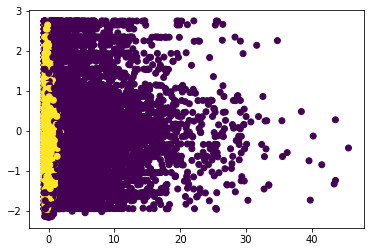

In [49]:
plt.scatter(pca_x[:, 0], pca_x[:, 1], c=label1)
plt.show()

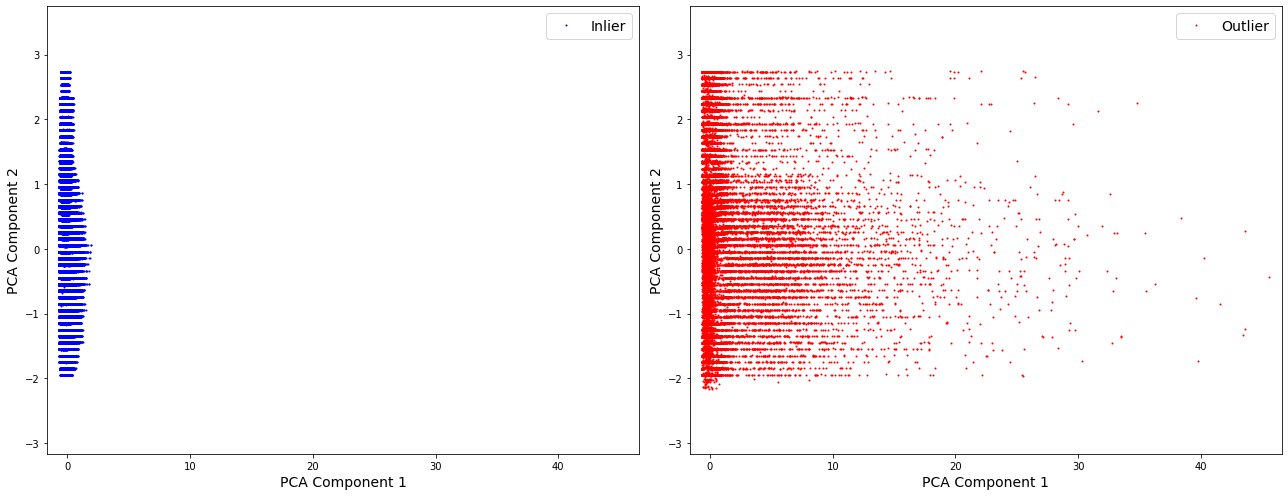

In [26]:
# visualization
inlier = pca_x[label == 1]
outlier = pca_x[label == -1]
xmin = pca_x[:, 0].min() - 1
xmax = pca_x[:, 0].max() + 1
ymin = pca_x[:, 1].min() - 1
ymax = pca_x[:, 1].max() + 1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(inlier[:, 0], inlier[:, 1], 'b.', markersize=2, label='Inlier')
ax[0].set_xlabel('PCA Component 1', fontsize=14)
ax[0].set_ylabel('PCA Component 2', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].set_xlim([xmin, xmax])
ax[0].set_ylim([ymin, ymax])
ax[1].plot(outlier[:, 0], outlier[:, 1], 'r.', markersize=2, label='Outlier')
ax[1].set_xlabel('PCA Component 1', fontsize=14)
ax[1].set_ylabel('PCA Component 2', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].set_xlim([xmin, xmax])
ax[1].set_ylim([ymin, ymax])
plt.tight_layout()
plt.show()

For other methods, please refer to: [Link](https://github.com/stasi009/TakeHomeDataChallenges/blob/master/10.CreditCard/credit_card_fraud.ipynb)